In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader import MultiModalDataset,VitalSignsDataset,vital_pre_train
from model.lstm_baseline import *
from model.autoencoder_v1_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()
from torchsampler import ImbalancedDatasetSampler


In [4]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)



train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(train_loader) 
inputs, lengths = next(small_data_iter)   

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_features = 154  
embedding_dim = 128
model =BaselineLSTM(n_features, embedding_dim,grid_size=(12,12)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [6]:
stage1 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage1'
model1, pretrain_history = pretrain_encoder_decoder(
    model, train_loader, device, optimizer, start=1, epochs=100, save_dir=stage1, patience=20
)

[Pretrain] Epoch 10/100, Loss=4.7799, saved checkpoint.
[Pretrain] Epoch 20/100, Loss=4.1920, saved checkpoint.
[Pretrain] Epoch 30/100, Loss=3.7707, saved checkpoint.
[Pretrain] Epoch 40/100, Loss=3.4433, saved checkpoint.
[Pretrain] Epoch 50/100, Loss=3.2508, saved checkpoint.
[Pretrain] Epoch 60/100, Loss=3.1327, saved checkpoint.
[Pretrain] Epoch 70/100, Loss=3.0405, saved checkpoint.
[Pretrain] Epoch 80/100, Loss=2.8757, saved checkpoint.
[Pretrain] Epoch 90/100, Loss=2.8441, saved checkpoint.
[Pretrain] Epoch 100/100, Loss=2.7712, saved checkpoint.


In [ ]:
stage1 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage1/best_pretrain_model.pth'
## load the best model
model1 =BaselineLSTM(n_features, embedding_dim,grid_size=(12,12)).to(device)
model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

In [7]:
model.use_som = True

lambda_cfg = {
    'kl': 1.0,
    'diversity': 0.05,
    'smooth': 0.03,
    'neighbor': 0.02,
    'l2': 1e-4
}
stage2 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage2'
optimizer = optim.Adam(model1.parameters(), lr=1e-3)
model2, joint_history = train_joint(
    model1, train_loader, val_loader, device, optimizer, start=1, epochs=100,
    save_dir=stage2, lambda_cfg=lambda_cfg, patience=40
)

[Joint] Epoch 10/100, Train=3.1963, Val=3.2408
[Joint] Epoch 20/100, Train=2.9735, Val=3.1711
[Joint] Epoch 30/100, Train=2.8079, Val=2.9277
[Joint] Epoch 40/100, Train=2.5837, Val=2.8121
[Joint] Epoch 50/100, Train=2.5628, Val=2.8451
[Joint] Epoch 60/100, Train=2.4361, Val=2.5383
[Joint] Epoch 70/100, Train=2.3610, Val=2.5080
[Joint] Epoch 80/100, Train=2.3423, Val=2.5331
[Joint] Epoch 90/100, Train=2.3128, Val=2.5159
[Joint] Epoch 100/100, Train=2.2938, Val=2.5190


In [5]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage2/best_joint_model.pth'
## load the best model
model2 =BaselineLSTM(n_features, embedding_dim,grid_size=(12,12)).to(device)
model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))
## load the history json file
joint_history = json.load(open(stage2.replace('best_joint_model.pth','history_joint.json'), 'r'))

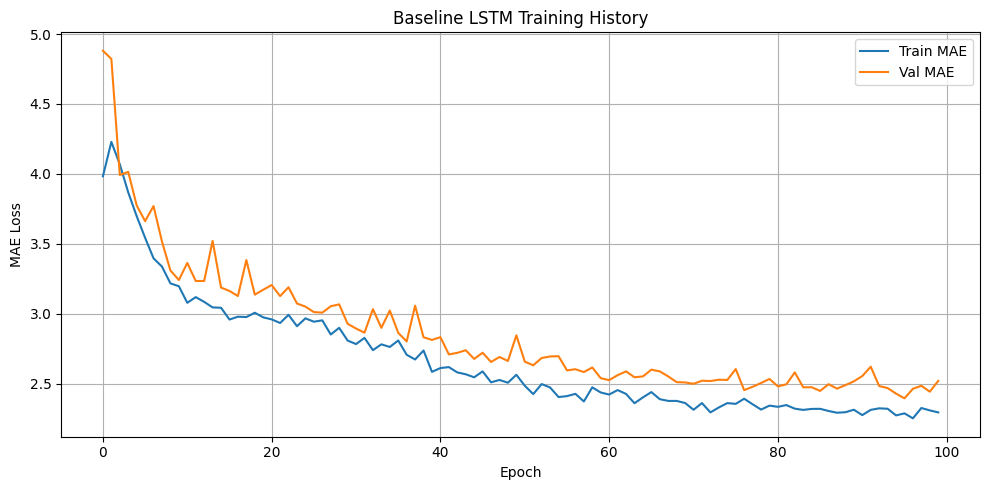

In [8]:
# joint_history = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage2/history_joint.json'
plot_baseline_history(joint_history)

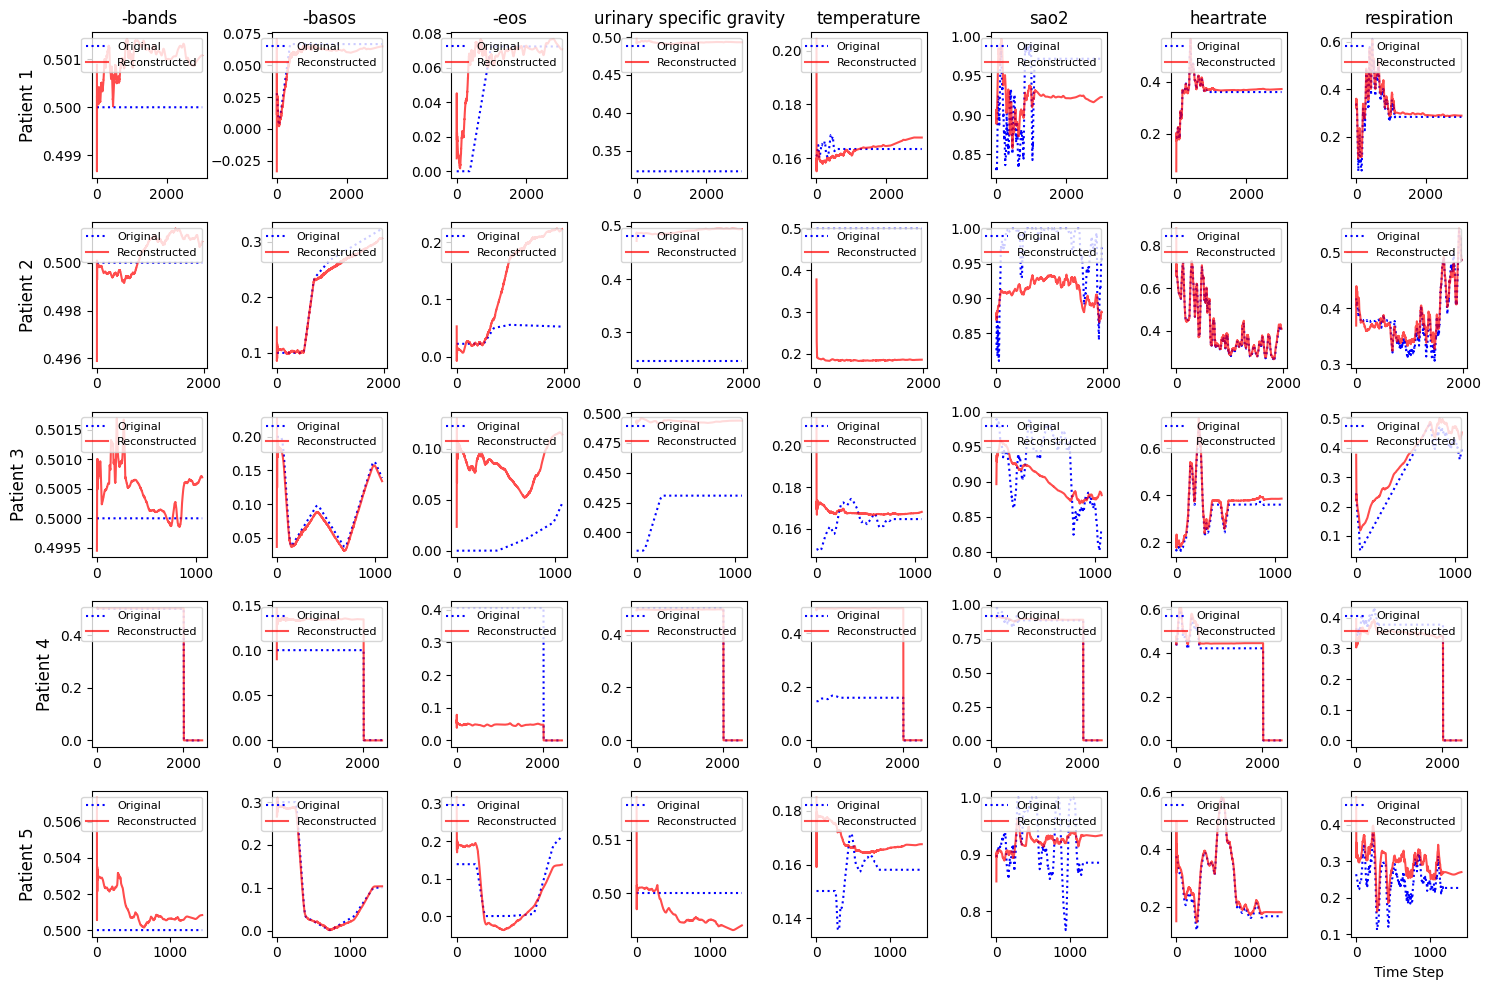

In [9]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model2, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)

In [10]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage2/best_joint_model.pth'
## load the best model
model =BaselineLSTM(n_features=154, embedding_dim=128,grid_size=(12,12)).to(device)
model.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))


<All keys matched successfully>

In [16]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np # 确保导入 numpy
import seaborn as sns # 确保导入 seaborn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence # 确保导入


# 假设 generate_mask 函数已经定义在别处或在此函数作用域内可见
def generate_mask(seq_len, actual_lens, device):
    actual_lens = actual_lens.to(device)
    arange_tensor = torch.arange(seq_len, device=device)
    mask = arange_tensor.expand(len(actual_lens), seq_len) < actual_lens.unsqueeze(1)
    return mask.float()

def visualize_latent_space(model, data_loader, device, num_samples_to_plot=100, use_tsne=True, perplexity_tsne=30, labels_available=False, save_path=None):
    """
    可视化潜空间的分布。
    Args:
        model: 训练好的模型 (例如 BaselineLSTM 实例)。
        data_loader: DataLoader，提供数据。
        device: "cuda" 或 "cpu"。
        num_samples_to_plot: 要绘制的样本数量。
        use_tsne: 是否使用 t-SNE (True) 或 PCA (False) 进行降维。
        perplexity_tsne: t-SNE 的 perplexity 参数。
        labels_available: 数据中是否有类别标签可用于着色。
                           假设 DataLoader 返回 (x, lengths, original_indices, other_info)
                           如果 labels_available=True, 假设 other_info 是类别标签。
        save_path: 保存图像的路径。
    """
    model.eval()
    # all_z_means = [] # 不再使用这个
    all_z_e_outputs = []
    all_labels = [] # 如果有标签
    collected_count = 0 # 修改计数器变量名以避免与外部作用域冲突

    print(f"Extracting latent representations for up to {num_samples_to_plot} samples...")
    with torch.no_grad():
        # 确保 data_loader 至少能提供足够的样本
        # for x_seq_batch, lengths_batch, _, other_info_batch in data_loader: # 调整以匹配你的dataloader输出
        # 假设你的dataloader返回 (x, lengths, original_indices, labels_or_other_info)
        # 如果你的dataloader只有 (x, lengths)，你需要修改标签获取逻辑或设置 labels_available=False
        for batch_idx, batch_data in enumerate(data_loader):
            if collected_count >= num_samples_to_plot:
                break

            # 解析批次数据 - 根据你的 DataLoader 输出进行调整
            if len(batch_data) == 2: # 假设 (x, lengths)
                x_seq_batch, lengths_batch = batch_data
                other_info_batch = None # 没有标签或其他信息
                if labels_available:
                    print("Warning: labels_available=True but DataLoader only provides 2 items (expected more for labels).")
                    current_labels_available = False
                else:
                    current_labels_available = False
            elif len(batch_data) == 4: # 假设 (x, lengths, original_indices, labels)
                x_seq_batch, lengths_batch, _, other_info_batch = batch_data
                current_labels_available = labels_available
            else:
                raise ValueError("DataLoader returned unexpected number of items in a batch.")


            x_seq_batch = x_seq_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            B, T_max, D_input = x_seq_batch.shape

            # 获取 LSTM Encoder 的输出 z_e
            packed_input = pack_padded_sequence(x_seq_batch, lengths_batch.cpu(), batch_first=True, enforce_sorted=False)
            z_e_packed, _ = model.encoder_lstm(packed_input) # 直接调用 encoder_lstm
            z_e_seq, _ = pad_packed_sequence(z_e_packed, batch_first=True, total_length=T_max)
            
            
            z_e_for_viz_list = []
            for i in range(B):
                valid_len = int(lengths_batch[i].item())
                if valid_len > 0:
                    # 对每个序列所有有效时间步的 z_e 取平均
                    z_e_for_viz_list.append(torch.mean(z_e_seq[i, :valid_len, :], dim=0).cpu())
            
            if not z_e_for_viz_list: # 如果这个批次没有有效长度的序列
                print(f"Batch {batch_idx} had no valid sequences, skipping.")
                continue
            
            z_e_for_viz_batch = torch.stack(z_e_for_viz_list)
            all_z_e_outputs.append(z_e_for_viz_batch)

            if current_labels_available and other_info_batch is not None:
                if isinstance(other_info_batch, torch.Tensor):
                    labels_batch_cpu = other_info_batch.cpu()
                     # 假设标签是序列级别的 (B, label_dims) or (B,)
                    if labels_batch_cpu.shape[0] == z_e_for_viz_batch.shape[0]: # 确保标签数量和提取的z数量一致
                        all_labels.append(labels_batch_cpu)
                    else:
                        print(f"Warning: Label batch size {labels_batch_cpu.shape[0]} mismatch with z_e batch size {z_e_for_viz_batch.shape[0]}. Skipping labels for this batch.")

                # elif isinstance(other_info_batch, (list, np.ndarray)): # 根据你的标签格式调整
                #     # 确保转换和对齐
                #     try:
                #         processed_labels = torch.tensor(other_info_batch[:z_e_for_viz_batch.shape[0]]) # 确保数量匹配
                #         all_labels.append(processed_labels)
                #     except Exception as e:
                #         print(f"Warning: Could not process labels of type {type(other_info_batch)}. Error: {e}")
                else:
                    print(f"Warning: Unexpected label format: {type(other_info_batch)}")


            collected_count += z_e_for_viz_batch.shape[0]
            # print(f"Collected {collected_count} samples so far...") # Debugging print
            if collected_count >= num_samples_to_plot:
                break
    
    if not all_z_e_outputs: # ***** 修改这里 *****
        print("No latent representations extracted.")
        return

    latent_vectors = torch.cat(all_z_e_outputs, dim=0) # ***** 修改这里 *****
    if latent_vectors.shape[0] > num_samples_to_plot:
         latent_vectors = latent_vectors[:num_samples_to_plot]
    
    print(f"Total latent vectors collected: {latent_vectors.shape[0]}")

    if labels_available and all_labels:
        true_labels = torch.cat(all_labels, dim=0)
        if true_labels.shape[0] > num_samples_to_plot:
            true_labels = true_labels[:num_samples_to_plot]
        
        # 确保标签数量与潜向量数量最终一致
        if true_labels.shape[0] != latent_vectors.shape[0]:
            print(f"Warning: Mismatch after collecting all labels ({true_labels.shape[0]}) and latent vectors ({latent_vectors.shape[0]}). Truncating to minimum.")
            min_len = min(true_labels.shape[0], latent_vectors.shape[0])
            true_labels = true_labels[:min_len]
            latent_vectors = latent_vectors[:min_len]
            if min_len == 0:
                print("Error: No consistent data/labels to plot.")
                return


        if true_labels.ndim > 1 and true_labels.shape[1] > 1: 
            true_labels_for_plot = true_labels[:, 0].numpy() # 取第一个标签维度
            print(f"Using first dimension of labels for coloring. Unique labels found: {np.unique(true_labels_for_plot)}")
        elif true_labels.ndim == 1:
            true_labels_for_plot = true_labels.numpy()
            print(f"Using labels for coloring. Unique labels found: {np.unique(true_labels_for_plot)}")
        else: # true_labels.ndim > 1 and true_labels.shape[1] == 1
            true_labels_for_plot = true_labels.squeeze().numpy()
            print(f"Using squeezed labels for coloring. Unique labels found: {np.unique(true_labels_for_plot)}")
    else:
        true_labels_for_plot = None
        print("No labels available or collected for coloring.")


    if latent_vectors.shape[0] == 0:
        print("No latent vectors to plot after all processing.")
        return

    print(f"Performing dimensionality reduction on {latent_vectors.shape[0]} latent vectors...")
    # ... (后续的降维和绘图逻辑保持不变) ...
    if latent_vectors.shape[1] == 2:
        latent_2d = latent_vectors.numpy()
        reducer_name = "Original 2D Latent"
    elif latent_vectors.shape[1] == 3 and not use_tsne: 
        print("Latent space is 3D. Consider a 3D scatter plot or PCA to 2D.")
        reducer = PCA(n_components=2)
        latent_2d = reducer.fit_transform(latent_vectors.numpy())
        reducer_name = "PCA to 2D"
    elif use_tsne:
        # 确保 perplexity 不大于样本数减1
        actual_perplexity = min(perplexity_tsne, latent_vectors.shape[0] - 1)
        if actual_perplexity < 5: # t-SNE 通常需要至少5的 perplexity
            print(f"Warning: Number of samples ({latent_vectors.shape[0]}) is too small for perplexity {perplexity_tsne}. Using perplexity={actual_perplexity if actual_perplexity > 0 else 1}.")
            if actual_perplexity <= 0: # 如果样本数是1或0
                 print("Not enough samples for t-SNE. Skipping visualization.")
                 return

        reducer = TSNE(n_components=2, perplexity=actual_perplexity, random_state=42,max_iter=300, init='pca', learning_rate='auto')
        latent_2d = reducer.fit_transform(latent_vectors.numpy())
        reducer_name = f"t-SNE (perplexity={actual_perplexity})"
    else:
        reducer = PCA(n_components=2)
        latent_2d = reducer.fit_transform(latent_vectors.numpy())
        reducer_name = "PCA to 2D"
    print("Dimensionality reduction complete.")

    plt.figure(figsize=(12, 10) if true_labels_for_plot is not None else (10,8) ) # 调整图像大小
    if true_labels_for_plot is not None and len(true_labels_for_plot) > 0:
        df_latent = pd.DataFrame({'Dim1': latent_2d[:, 0], 'Dim2': latent_2d[:, 1], 'Label': true_labels_for_plot})
        
        unique_labels = df_latent['Label'].unique()
        num_unique_labels = len(unique_labels)
        
        if num_unique_labels == 0:
            print("No unique labels to plot with hue. Plotting without hue.")
            plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=50, alpha=0.5)
        else:
            palette = sns.color_palette("hsv", num_unique_labels) if num_unique_labels > 10 else sns.color_palette("deep", n_colors=num_unique_labels)
            
            sns.scatterplot(x='Dim1', y='Dim2', hue='Label', palette=palette, data=df_latent, legend='full', s=50, alpha=0.7)
            plt.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    else:
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=50, alpha=0.5)
    
    plt.title(f"Latent Space Visualization ({reducer_name})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True, linestyle=':', alpha=0.6)
    
    # 调整布局以容纳图例
    if true_labels_for_plot is not None and len(true_labels_for_plot) > 0 and num_unique_labels > 0 :
        plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    else:
        plt.tight_layout()
        
    if save_path:
        plt.savefig(save_path, bbox_inches='tight') # bbox_inches='tight' 确保图例被保存
        print(f"Latent space visualization saved to {save_path}")
    plt.show()

Extracting latent representations for up to 100 samples...
Total latent vectors collected: 100
Using labels for coloring. Unique labels found: [0 1 2 3]
Performing dimensionality reduction on 100 latent vectors...
Dimensionality reduction complete.


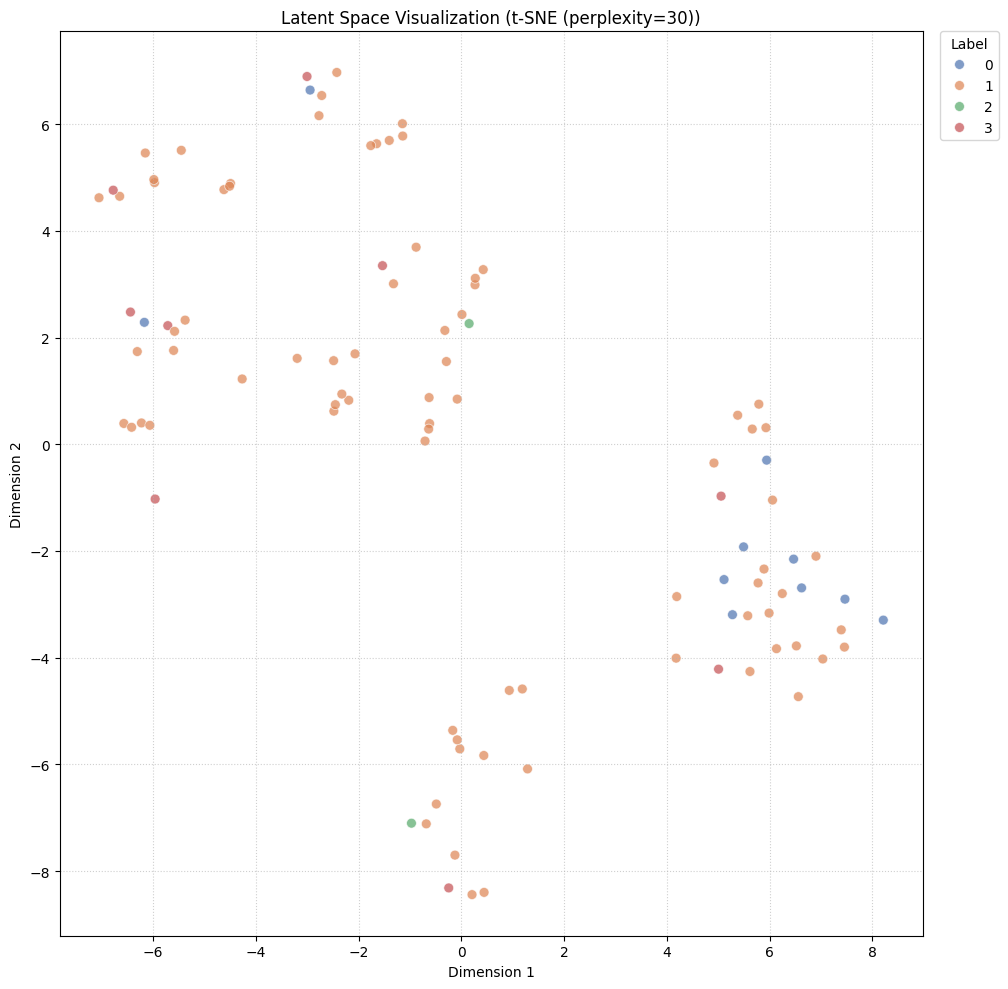

In [17]:
visualize_latent_space(model, test_loader, device, num_samples_to_plot=100, use_tsne=True, perplexity_tsne=30, labels_available=True)